In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

#定义超参数
image_size = 28  # image size 28*28
num_classes = 10 # 标签的种类
num_epochs = 20  # 训练的循环周期
batch_size = 64  # 一个批次的大小，64张图片

(1, 28, 28)
训练集多少批： 938
训练集总共多少条： 60000
校验集多少批： 79
校验集总共多少条： 10000
测试集多少批： 79
测试集总共多少条： 10000
The label is:  5


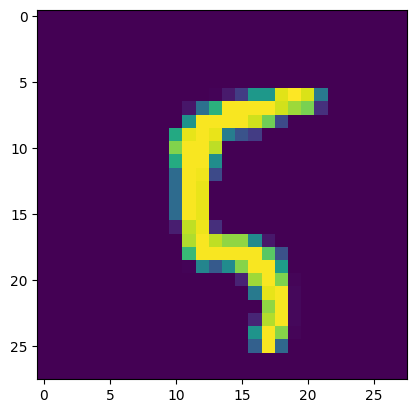

The label is:  7


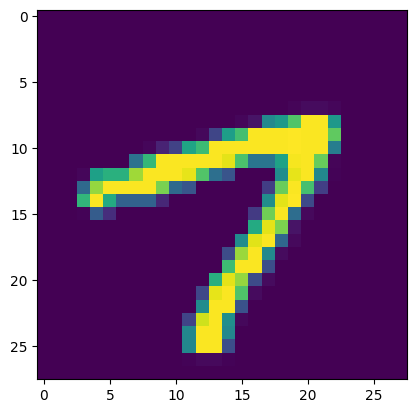

The label is:  1


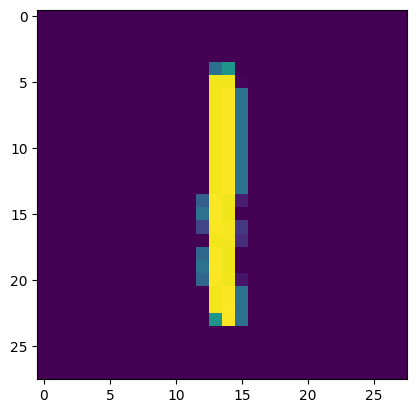

In [87]:
train_datasets = dsets.MNIST(root='./5_convolution_data', # 文件存放路径
                             train = True,  # 提取训练集
                             transform=transforms.ToTensor(), #将图像转化为Tensor
                             download = True)  # 找不到文件的时候自动下载
print(train_datasets[0][0].data.numpy().shape)

# 加载测试数据集
test_datasets = dsets.MNIST(root='./5_convolution_data', # 文件存放路径
                             train = False,  # 提取训练集
                             transform=transforms.ToTensor(),) #将图像转化为Tensor
                           
#  自动将数据切分成批，打乱顺序
train_loader = torch.utils.data.DataLoader(dataset = train_datasets,
                                           batch_size = batch_size,
                                           shuffle = True)
print('训练集多少批：', len(train_loader))
print('训练集总共多少条：', len(train_loader.dataset))

# 测试数据分为两部分，一部分校验用验证是否过拟合，一部分测试
indices = range(len(test_datasets))
indices_validate = indices[:5000]
indices_test = indices[5000:]

# 数据采样器
sampler_validate = torch.utils.data.sampler.SubsetRandomSampler(indices_validate)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据采样器定义加载器
validate_loader = torch.utils.data.DataLoader(dataset = test_datasets,
                                              batch_size = batch_size,
                                              shuffle = False,
                                              sampler = sampler_validate)
                                             
test_loader = torch.utils.data.DataLoader(dataset = test_datasets,
                                              batch_size = batch_size,
                                              shuffle = False,
                                              sampler = sampler_test)
print('校验集多少批：', len(validate_loader))
print('校验集总共多少条：', len(validate_loader.dataset))
print('测试集多少批：', len(test_loader))
print('测试集总共多少条：', len(test_loader.dataset))
def show_raw_img(idx):
    muteimg = train_datasets[idx][0].data.numpy()
    plt.imshow((muteimg[0,...]))   # 因为维度是1*28*28，  所以切片的第一维度索引是0， 即提取 28*28 
    print('The label is: ', train_datasets[idx][1])
    plt.show()
                                           
# 随便从数据集中读入一张图片
show_raw_img(100)
show_raw_img(101)
show_raw_img(102)

In [60]:
# 构建卷积神经网络
depth = [4, 8] # 卷积层的厚度

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()  # 调用父类构造函数

        # 卷积后图像维度不变， size + padding * 2 - kernel_size + 1 = size + 4 - 5 + 1 = size
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 5, padding = 2) # 卷积层
        
        self.pool = nn.MaxPool2d(2, 2) #  池化层
        
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) # 第二层卷积

        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512) 
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # 神经网络完成真正的前向运算，拼装各个实际的组件
        x = self.conv1(x) # 第一层卷积
        x = F.relu(x)  # (batch_size, num_filters, image_width, image_height]

        x = self.pool(x) # 第二层池化，图片变小：(batch_size, num_filters, image_width / 2, image_height / 2]

        x = self.conv2(x) #第三层卷积, (batch_size, depth[1], image_width / 2, image_height / 2]
        x = F.relu(x)  

        x = self.pool(x) #第四层池化， 图片缩小 (batch_size, depth[1], image_width / 2 / 2, image_height / 2 / 2]

        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])  # 压缩向量

        x = F.relu(self.fc1(x)) # 第五层为全连接  (batch_size, 512)

        x = F.dropout(x, training = self.training) # 默认以0.5的概率对这一层进行dropout操作，防止过拟合
        x = self.fc2(x)  # 全连接层，最终输出 （batch_size, num_classes）

        x = F.log_softmax(x, dim=1)
        return x

    def retrieve_features(self, x):
        # 返回前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)

        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)
        
# 计算分类准确度
def rightness(predictions, labels):
    # max函数返回[value, index], pred得到最大概率的索引，0表示好，1表示负面
    pred = torch.max(predictions.data, 1)[1] # max的dim=1 表示沿着第二个维度计算max，即好或坏两个分类数值， 

    rights = pred.eq(labels.data.view_as(pred)).sum()

    return rights, len(labels)

In [ ]:
net = ConvNet() # 自动调用实例的init函数

criterion = nn.CrossEntropyLoss() # 定义损失函数
# 动量法每下降一步都是由前面下降方向的一个累积和（衰减系数momentum）当前点的梯度方向组合而成。
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 定义优化器, 小批量loss更新的梯度下降算法。 momentum动量法

record = []
weights = []

for epoch in range(num_epochs):
    train_rights = []
    # data维度: [64, 1, 28, 28], target维度: [64], target存储的是索引值
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # train()方法是用于在训练神经网络时启用dropout、batch normalization和其他特定于训练的操作的函数。
        net.train()
        
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad() # 清空梯度 
        loss.backward()
        optimizer.step()  # 随机梯度下降算法更新权重

        right = rightness(output, target) # 计算准确率
        train_rights.append(right)

        if batch_idx % 100 == 0:
            net.eval() # 不运行dropout，BN等训练层
            validate_rights = []

            for (data, target) in validate_loader:
                output = net(data)
                
                right = rightness(output, target)
                validate_rights.append(right)

            # 训练集准确度=train_r[0] / train_r[1]
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            # 校验集准确度=validate_r[0] / validate_r[1]
            validate_r = (sum([tup[0] for tup in validate_rights]), sum([tup[1] for tup in validate_rights]))

            # 计算一个epoch周期内的 准确率
            # 训练周期: 0 [12800 / 60000 (21%)]	, Loss: 2.259433	, 训练正确率: 14.70%	, 校验正确率: 30.50%
            print('训练周期: {} [{} / {} ({:.0f}%)]\t, Loss: {:.6f}\t, 训练正确率: {:.2f}%\t, 校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.data,
                100. * train_r[0] / train_r[1],
                100. * validate_r[0] / validate_r[1]
            ))

            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * validate_r[0] / validate_r[1]))
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(),
                           net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])

训练周期: 0 [0 / 60000 (0%)]	, Loss: 2.296101	, 训练正确率: 12.50%	, 校验正确率: 9.20%
训练周期: 0 [6400 / 60000 (11%)]	, Loss: 2.296712	, 训练正确率: 11.26%	, 校验正确率: 9.20%
训练周期: 0 [12800 / 60000 (21%)]	, Loss: 2.280974	, 训练正确率: 13.27%	, 校验正确率: 12.54%
